In [2]:
import pymc3 as pm
import numpy as np
import pandas as pd
import theano.tensor as tt
import seaborn as sns
import scipy.stats as stats   
from scipy.special import expit as logistic
import matplotlib.pyplot as plt
import arviz as az

In [5]:
az.style.use('arviz-darkgrid')

在上一章中，我们使用输入变量的线性组合来预测输出变量的平均值。 我们假设后者以高斯分布。 在许多情况下使用高斯函数是可行的，但在其他许多情况下，选择不同的分布可能更明智。 当我们用学生的t分布替换高斯分布时，我们已经看到了一个例子。 在本章中，我们将看到更多使用高斯分布以外的分布的明智示例。 我们将学习到，存在一个通用的主题或模式，可用于将线性模型推广到许多问题。

#### 本章的核心思想很简单：为了预测输出变量的平均值，我们可以将任意函数应用于输入变量的线性组合。

Where is a function, we will call inverse link function. There are many inverse link functions we can choose; probably the simplest one is the identity function. This is a function that returns the same value used as its argument. All models from Chapter 3 , Modeling with Linear Regression used the identity function, and for simplicity we just omit it. The identity function may not be very useful on its own, but it allows us to think of several different models in a more unified way.

为什么我们称f为逆链接函数，而不仅仅是链接函数？ 因为传统上人们将函数应用于等式4.1的另一端，但不幸的是，对于我们来说，他们已经在术语“链接函数”上称为dibs-为避免混淆，我们将坚持使用术语“反向链接函数”。

在使用分类变量（例如颜色名称，性别，生物物种或政党/隶属关系）时，我们想使用反向链接功能的一种情况。这些变量都没有被高斯人很好地建模。考虑一下，从原理上讲，高斯算法对于在实线上取任意值的连续变量都适用，而此处提到的变量是离散的，并且仅取几个值（例如红色，绿色或蓝色）。如果更改用于建模数据的分布，则通常还需要更改对这些分布的均值的合理值建模的方式。例如，如果我们使用二项式分布，例如在第1章，概率性思考和第2章，概率性编程中，我们将需要一个线性模型，该模型返回[0，1]区间内的平均值；实现此目的的一种方法是保留线性模型，但使用反向链接功能将输出限制为所需的间隔。这个技巧不仅仅限于离散变量。我们可能希望对只能采用正值的数据进行建模，因此我们可能希望限制线性模型以返回正态分布平均值，例如Gamma或指数。

在继续之前，请注意，可以将一些变量编码为定量或定性的，这是您必须根据问题的上下文来做出的决定； 例如，如果讨论颜色名称，则可以讨论红色和绿色类别变量；如果使用波长，则可以涉及650 nm和510 nm连续变量。

## Logistic regression

回归问题是关于在给定一个或多个输入变量的值的情况下预测输出变量的连续值。 相反，分类是关于在给定某些输入变量的情况下向输出变量分配离散值（代表离散类）。 在这两种情况下，任务都是获得一个模型，以正确地模拟输出和输入变量之间的映射。 为了做到这一点，我们可以使用一个带有正确的输出-输入变量对的样本。 从机器学习的角度来看，回归和分类都是监督学习算法的实例。

我的母亲准备了一道美味的菜，称为sopa seca，这基本上是基于意大利面条的食谱，字面上意味着干汤。 虽然这听起来像是用词不当，甚至是矛盾的意思，但当我们学习如何烹饪时，这道菜的名字就很有意义了。 Logistic回归也会发生类似的情况，尽管该模型具有其名称，但通常被认为是解决分类问题的一种方法。

Logistic回归模型是第3章“使用线性回归建模”中线性回归模型的概括，因此得名。 我们通过在4.1中将logistic函数作为反向链接函数代替来实现这种概括：

![title](4_1.png)

就我们的目的而言，逻辑函数的关键属性是，无论其参数的值如何，结果始终为[0-1]区间内的数字。 因此，我们可以看到此函数是将线性模型计算出的值压缩为可以输入到伯努利分布中的值的便捷方法。 由于它具有S形特征，因此该逻辑函数也称为Sigmoid函数，如执行以下几行所示：

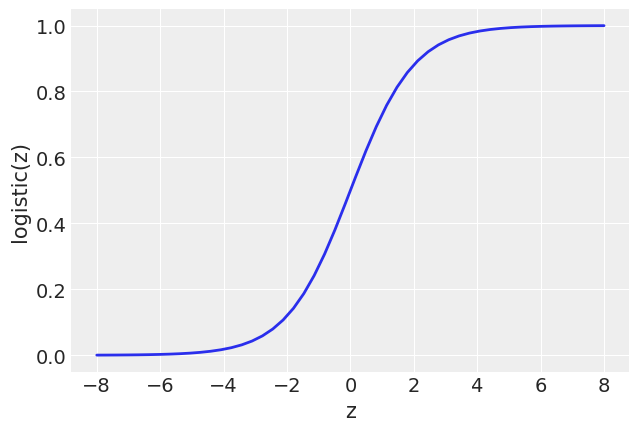

In [6]:
z = np.linspace(-8, 8)
plt.plot(z, 1 / (1 + np.exp(-z)))
plt.xlabel('z')
plt.ylabel('logistic(z)')
plt.savefig('B11197_04_01.png', dpi=300);

我们几乎拥有将简单的线性回归转变为简单的逻辑回归的所有要素。 让我们从只有两个类或实例的情况开始，例如火腿/垃圾邮件，安全/不安全，多云/晴天，健康/生病或热狗/非热狗。 首先，我们通过说预测变量只能取两个值0或1来对这些类进行整理。 这样说，问题听起来与第2章概率编程和第3章线性回归建模中的掷硬币示例相似。

我们可能还记得我们使用伯努利分布作为似然。 掷硬币问题的不同之处在于，现在不会从beta分布中生成硬币。 取而代之的是，将通过线性模型定义逻辑模型，并将逻辑模型作为反向链接函数。 省略先验条件：【注意，与第3章“使用线性回归建模”中的简单线性回归的主要区别在于，使用伯努利分布代替高斯分布，并使用逻辑函数代替恒等函数。】

![title](4_2.png)

## The iris dataset

我们将逻辑回归应用于鸢尾花数据集。 这是一个经典的数据集，其中包含有关三个紧密相关物种的花朵的信息：刚毛，弗吉尼亚州和杂色。 这些将成为我们的因变量，即我们要预测的类。 我们每个物种有50个个案，对于每个个案，数据集包含四个将用作自变量（或特征）的变量：花瓣长度，花瓣宽度，萼片长度和萼片宽度。 如果您想知道，萼片是经过修饰的叶子，其功能通常与保护芽中的花朵有关。 通过执行以下操作，我们可以使用鸢尾花数据集加载数据框：

In [4]:
iris = pd.read_csv('../data/iris.csv')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


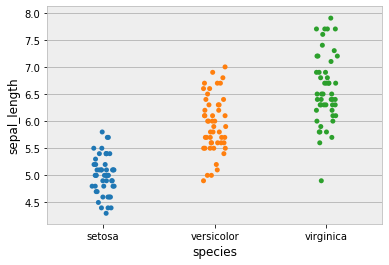

In [60]:
sns.stripplot(x="species", y="sepal_length", data=iris, jitter=True)  #分类散点图
plt.savefig('B11197_04_02.png', dpi=300);

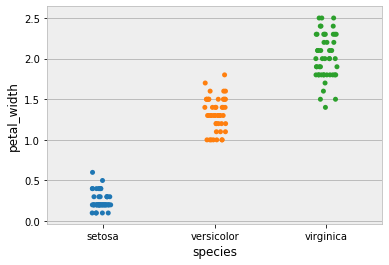

In [61]:
sns.stripplot(x="species", y="petal_width", data=iris, jitter=True)  #分类散点图

在图4.2中，y轴是连续的，而x轴是分类的。 沿x轴的点的色散（或抖动）根本没有任何意义，这只是我们在jitter参数中添加的一种技巧，可以避免将所有点折叠到一条直线上。 尝试将抖动参数设置为False，以了解我的意思。 读取x轴时唯一重要的是setosa，versicolor或virginica类的点的成员资格。 您也可以尝试使用其他图来获取此数据，例如小提琴图，这些图也可以作为带有seaborn的单线使用。

核密度估计完全利用数据本身信息，避免人为主观带入得先验知识，从而能够对样本数据进行最大程度得近似（相对于参数估计）。而多样得核函数也为实际应用中提供了选择，但在带宽的选择上存在一些问题，当然可以根据上面的推导为带宽的选择提供一些方向。至于实现方面，sklearn核scipy都对核密度估计进行了实现核优化，这应该是个不错的选择。属于非参数估计的方法，直方图受bin分箱大小的差别影响，展示的分布曲线并不平滑。

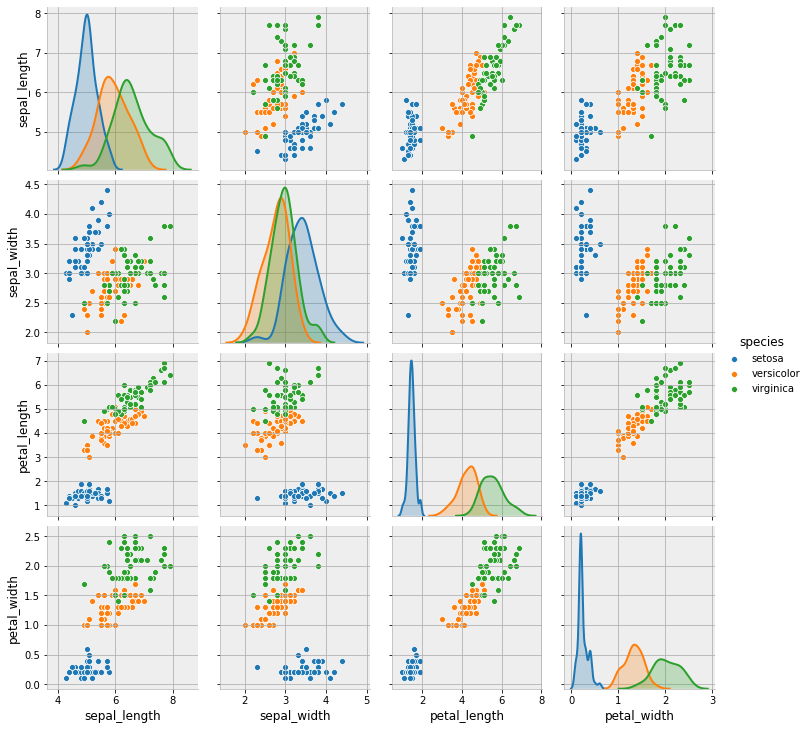

In [6]:
sns.pairplot(iris, hue='species', diag_kind='kde') #sns.pairplot 主要展现的是变量两两之间的关系 ；hue ：针对某一字段进行分类
#kind：用于控制非对角线上的图的类型，可选"scatter"与"reg" ;diag_kind：控制对角线上的图的类型，可选"hist"与"kde"
plt.savefig('B11197_04_03.png', dpi=300, bbox_inches='tight');

检查数据的另一种方法是通过使用pairplot函数创建散布矩阵。 由于在鸢尾花数据集中有四个要素，因此散点图以网格形式排列。 网格是对称的，上下三角形显示相同的信息。 主对角线上的散点图应对应于针对自身的变量； 鉴于这样的绘图根本无法提供信息，因此我们已针对每个要素用kde替换了这些散点图。 在每个子图中，我们用不同的颜色表示三种物种（或类），与图4.2中使用的颜色相同：

### The logistic model applied to the iris dataset

我们将从最简单的分类问题开始：两个类，setosa和versicolor，以及一个独立变量或特征sepal_length。 通常，我们将使用数字0和1编码setosa和versicolor分类变量。使用pandas，我们可以执行以下操作：

请注意，model_0的第一部分如何类似于线性回归模型。 还要注意两个确定性变量：θ和bd。 θ是应用于μ变量的逻辑函数的输出，bd是边界决策，边界决策是用于分离类的值； 我们将在后面详细讨论(决策边界定义为xi的值，当y = 0.5)。 值得一提的另一点是，我们使用的是pm. math. sigmoid ，而不是显式地编写逻辑函数（这只是Theano函数的同名别名）：

In [5]:
df = iris.query("species == ('setosa', 'versicolor')")
y_0 = pd.Categorical(df['species']).codes
x_n = 'sepal_length' 
x_0 = df[x_n].values
x_c = x_0 - x_0.mean()

In [6]:
with pm.Model() as model_0:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=10)
    
    μ = α + pm.math.dot(x_c, β)    
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ))
    bd = pm.Deterministic('bd', -α/β)
    
    yl = pm.Bernoulli('yl', p=θ, observed=y_0)

    trace_0 = pm.sample(1000, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [β, α]
Sampling chain 1, 0 divergences: 100%|████████████████████████████████████████████| 1500/1500 [00:01<00:00, 830.73it/s]


In [23]:
az.summary(trace_0)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α,0.299,0.338,-0.316,0.896,0.009,0.008,1408.0,910.0,1433.0,996.0,1.0
β,5.381,0.994,3.468,7.112,0.027,0.019,1392.0,1339.0,1434.0,1261.0,1.0
θ[0],0.163,0.057,0.061,0.267,0.001,0.001,1696.0,1696.0,1648.0,1265.0,1.0
θ[1],0.067,0.035,0.012,0.129,0.001,0.001,1702.0,1702.0,1606.0,1283.0,1.0
θ[2],0.027,0.019,0.001,0.060,0.000,0.000,1680.0,1665.0,1567.0,1339.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
θ[96],0.813,0.064,0.695,0.923,0.002,0.001,1430.0,1404.0,1369.0,1152.0,1.0
θ[97],0.980,0.016,0.951,0.999,0.000,0.000,1415.0,1415.0,1371.0,1368.0,1.0
θ[98],0.163,0.057,0.061,0.267,0.001,0.001,1696.0,1696.0,1648.0,1265.0,1.0
θ[99],0.813,0.064,0.695,0.923,0.002,0.001,1430.0,1404.0,1369.0,1152.0,1.0


In [7]:
varnames = ['α', 'β', 'bd']
az.summary(trace_0, varnames)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α,0.319,0.335,-0.307,0.935,0.009,0.007,1386.0,1061.0,1397.0,946.0,1.0
β,5.360,1.025,3.571,7.244,0.028,0.020,1303.0,1274.0,1311.0,1283.0,1.0
bd,-0.059,0.062,-0.174,0.057,0.002,0.001,1466.0,1247.0,1467.0,1209.0,1.0


In [9]:
with pm.Model() as model_0_1:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=10)
    
    μ = α + β*x_c    
    θ = pm.Deterministic('θ', pm.math.invlogit(μ))
    bd = pm.Deterministic('bd', -α/β)
    
    yl = pm.Binomial('yl', p=θ,n=1, observed=y_0)

    trace_0_1 = pm.sample(1000, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [β, α]
Sampling chain 1, 0 divergences: 100%|████████████████████████████████████████████| 1500/1500 [00:01<00:00, 781.37it/s]


In [10]:
az.summary(trace_0_1, varnames)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α,0.304,0.342,-0.373,0.917,0.009,0.007,1546.0,1164.0,1544.0,1281.0,1.0
β,5.391,1.020,3.405,7.163,0.027,0.019,1436.0,1404.0,1430.0,1043.0,1.0
bd,-0.056,0.064,-0.176,0.066,0.002,0.001,1618.0,1378.0,1617.0,1565.0,1.0


In [12]:
trace_0['θ'].shape

(2000, 100)

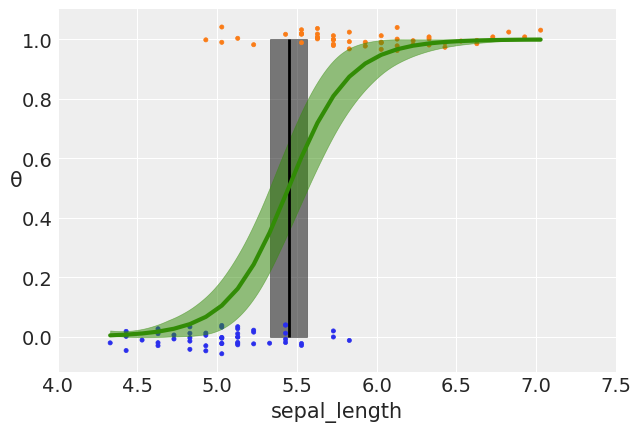

In [18]:
theta = trace_0['θ'].mean(axis=0)
idx = np.argsort(x_c)
plt.plot(x_c[idx], theta[idx], color='C2', lw=3)
plt.vlines(trace_0['bd'].mean(), 0, 1, color='k')
bd_hpd = az.hpd(trace_0['bd'])
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='k', alpha=0.5)

plt.scatter(x_c, np.random.normal(y_0, 0.02),
            marker='.', color=[f'C{x}' for x in y_0])
az.plot_hpd(x_c, trace_0['θ'], color='C2')

plt.xlabel(x_n)
plt.ylabel('θ', rotation=0)
# use original scale for xticks
locs, _ = plt.xticks()
plt.xticks(locs, np.round(locs + x_0.mean(), 1))
plt.savefig('B11197_04_04.png', dpi=300)

In [16]:
import scipy
mu=a+bx
mu=scipy.special.logit(p=0.5)
p=scipy.special.expit(mu=0)  #1/(1+e^0)=1/2

0.5

图4.4显示了萼片长度与鸢尾花种类的关系（setosa = 0，versicolor = 1）。 为避免过度绘图，二进制响应变量会抖动。 S形（绿色）线是的平均值。 假定我们知道萼片长度的值，这条线可以解释为花是杂色的概率。 半透明的S形（绿色）带为94％HPD间隔。 边界决策表示为（黑色）垂直线，其94％HPD具有半透明带。 根据边界决定，左边的值（在这种情况下为瓣片长度）对应于0类（setosa），右边的值对应于1类（versicolor）。

![title](4_3.png)

通常，$ \ theta $的值为p（y = 1 | x）。 从这个意义上说，逻辑回归是真正的回归； 关键的细节是，考虑到特征的线性组合，我们正在回归数据点属于1类的概率。我们正在模拟二分变量的均值，即[0-1]区间中的数字。 然后，我们引入一个规则，将这种可能性转换为两类分配。 在这种情况下，如果p（y = 1）> = 0.5，我们将分配类别1，否则将分配类别0。0.5的值没有什么特别的，除了它是介于0和1中间的数字。我们可能会争辩说，只有当我们可以在一个方向或另一个方向上出错时，该边界才是合理的。 换句话说，如果我们将setosa错误分类为杂色或将versicolor错误分类为setosa是相同的话。 事实证明，情况并非总是如此，与未分类相关的成本也不必是对称的，正如您在第二章“概率编程”中讨论损失函数时所记得的那样。

# Multiple logistic regression

与多元线性回归相似，多元逻辑回归是使用多个自变量。 让我们尝试结合萼片长度和萼片宽度。 请记住，我们需要对数据进行一些预处理：

In [3]:
df = iris.query("species == ('setosa', 'versicolor')") 
y_1 = pd.Categorical(df['species']).codes 
x_n = ['sepal_length', 'sepal_width'] 
x_1 = df[x_n].values

In [4]:
with pm.Model() as model_1: 
    α = pm.Normal('α', mu=0, sd=10) 
    β = pm.Normal('β', mu=0, sd=2, shape=len(x_n)) 
     
    μ = α + pm.math.dot(x_1, β) 
    θ = pm.Deterministic('θ', 1 / (1 + pm.math.exp(-μ))) 
    bd = pm.Deterministic('bd', -α/β[1] - β[0]/β[1] * x_1[:,0])  #下图中是对称的x1
     
    yl = pm.Bernoulli('yl', p=θ, observed=y_1) 
 
    trace_1 = pm.sample(2000,cores=1)

C:\Users\zhaolei\Anaconda3\lib\site-packages\theano\gpuarray\dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [β, α]
Sampling chain 1, 0 divergences: 100%|█████████████████████████████████████████████| 2500/2500 [00:25<00:00, 96.26it/s]
The acceptance probability does not match the target. It is 0.8861501923488824, but should be close to 0.8. Try to increase the number of tuning steps.


![title](4_4.png)

边界决策的表达式具有与线方程相同的数学形式，其中第一个为截距，第二个为斜率。 括号是为了清楚起见，如果需要，我们可以省略它们。 一条线的边界是完全合理的，不是吗？ 如果我们具有一个特征，则我们具有一维数据，我们可以使用一个点将其分为两组。 如果我们有两个功能，则我们有一个二维数据空间，我们可以用一条线将其分开。 对于三个维度，边界将是一个平面； 对于更高的维度，我们将泛泛地讨论超平面。 实际上，超平面是一个广义的概念，大致定义为n维空间的n-1维子空间，因此我们总是可以谈论超平面！

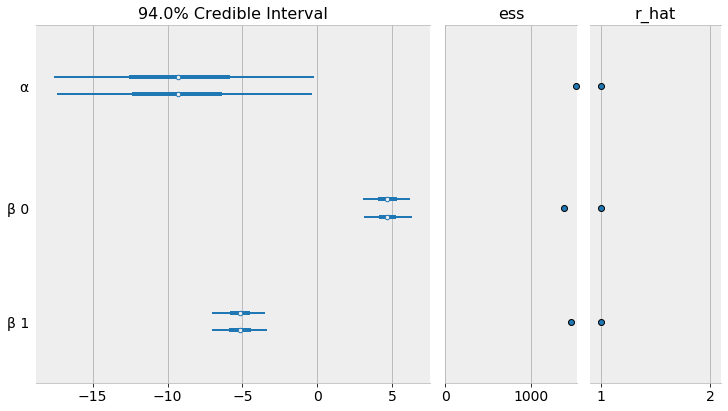

In [6]:
varnames = ['α', 'β'] 
az.plot_forest(trace_1, var_names=varnames,r_hat=True,ess=True);

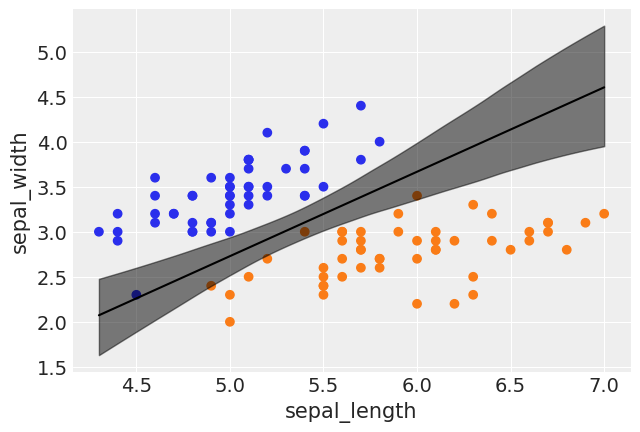

In [14]:
idx = np.argsort(x_1[:,0]) 
bd = trace_1['bd'].mean(0)[idx] 
plt.scatter(x_1[:,0], x_1[:,1], c=[f'C{x}' for x in y_0]) 
plt.plot(x_1[:,0][idx], bd, color='k'); 

az.plot_hpd(x_1[:,0], trace_1['bd'], color='k')
 
plt.xlabel(x_n[0]) 
plt.ylabel(x_n[1])
plt.savefig('B11197_04_05.png', dpi=300);

正如我们已经看到的，边界决定是一条直线。 不要对94％HPD频段的弯曲部分感到困惑。 视在曲率是多条线围绕中心区域（大致围绕x的平均值和y的平均值）枢转的结果。

## Interpreting the coefficients of a logistic regression 解释逻辑回归的系数

在解释逻辑回归的$ \ beta $系数时，我们必须小心。 解释并不像线性模型那样简单，线性模型在第3章“使用线性回归建模”中进行了介绍。 使用逻辑逆链接函数引入了我们必须考虑的非线性。 如果$ \ beta $是正数，则增加x将使p（y = 1）增加一定量，但该量不是的线性函数； 相反，它非线性地取决于x的值。 我们可以在图4.4中看到这个事实。 而不是具有恒定斜率的直线，我们有一条S形曲线，其斜率随x的变化而变化。 一点代数可以使我们对$ \ beta $的p（y = 1）变化量有更多的了解：

![title](4_5.png)

![title](4_6.png)

成功几率定义为成功几率与未成功几率之比。 虽然通过掷一个公平的骰子得到2的概率是1/6，但同一事件的几率是1/6 / 5/6 = 0.2或一个有利事件相对于五个不利事件。 赌徒经常使用赔率，主要是因为在考虑正确的下注方式时，赔率比原始概率提供了更直观的工具。

从概率到几率的转换是单调变换，这意味着几率随着概率的增加而增加，反之亦然。 尽管概率限制为[0，1]区间，但赔率仍在[0，∞）区间内。 对数是另一个单调变换，对数几率在（-∞，∞）区间内。 图4.6显示了概率与几率和对数几率之间的关系：

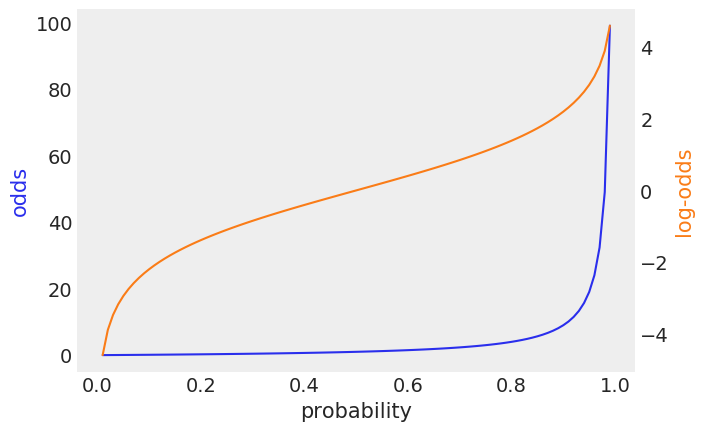

In [15]:
probability = np.linspace(0.01, 1, 100)
odds = probability / (1 - probability)

_, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(probability, odds, 'C0')
ax2.plot(probability, np.log(odds), 'C1')

ax1.set_xlabel('probability')
ax1.set_ylabel('odds', color='C0')
ax2.set_ylabel('log-odds', color='C1')
ax1.grid(False)
ax2.grid(False)
plt.savefig('B11197_04_06.png', dpi=300);

In [27]:
df = az.summary(trace_1, var_names=varnames)
df

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α,-9.272,4.624,-17.817,-0.500,0.131,0.092,1252.0,1252.0,1250.0,1582.0,1.0
β[0],4.688,0.900,3.054,6.358,0.025,0.018,1299.0,1299.0,1293.0,1504.0,1.0
β[1],-5.172,1.007,-6.997,-3.167,0.026,0.018,1515.0,1485.0,1525.0,1365.0,1.0


了解模型的一种非常实用的方法是更改参数并查看会发生什么。 在下面的代码块中，我们计算对数几率（支持versicolor），然后使用logistic函数计算versicolor的概率。 然后，我们通过固定x2并将x1增加1来重复计算：

![title](4_7.png)

如果运行代码，您将发现对数几率的增加是4.66，恰好是$ \ beta0 $的值（请检查trace_1的摘要）。 这与我们先前的发现一致，该发现通过x变量的单位增加对对数几率单位的增加进行编码。 概率增加为0.7。同理对于x2

In [30]:
x_1 = 4.5  # sepal_length
x_2 = 3   # sepal_width 

log_odds_versicolor_i = (df['mean'] * [1, x_1, x_2]).sum()
probability_versicolor_i = logistic(log_odds_versicolor_i)


log_odds_versicolor_f = (df['mean'] * [1, x_1 +1, x_2]).sum()
probability_versicolor_f = logistic(log_odds_versicolor_f)

log_odds_versicolor_f - log_odds_versicolor_i, probability_versicolor_f - probability_versicolor_i

(4.688000000000001, 0.7059553049207136)

## Dealing with correlated variables

从第3章“使用线性回归建模”可以知道，当我们处理（高度）相关变量时，棘手的事情在等待着我们。 相关变量可以转换为能够解释数据的更广泛的系数组合，或者从互补的角度来看，相关数据对模型的约束能力较小。 当类变得完全可分离时，即在给定模型中变量的线性组合的类之间没有重叠时，会发生类似的问题。

图4.7是一个热图，它显示了在第一个示例中使用的sepal_length和setal_width变量时，相关性不如在第二个示例中使用的petal_length和petal_width变量之间的相关性高：

要生成图4.7，我们使用了一个遮罩来删除热图的上三角和对角元素，因为在给定下三角的情况下，这些元素无用。 还要注意，我们已经绘制了相关的绝对值，因为此时我们不关心变量之间的相关符号，而只关心其强度。

处理（高度）相关变量时的一种解决方案是仅删除一个（或多个）相关变量。 另一个选择是将更多信息放入先验信息中，如果我们有有用的信息，可以使用信息先验信息来实现。 对于信息量较弱的先验，Andrew Gelman和Stan团队建议（https: //github. com/stan-dev/stan/wiki/Prior-Choice-Recommendations）将所有非二进制变量均值均值设置为0，然后 使用：

![title](4_8.png)

在这里，应该选择sd以便弱告知我们该scale的期望值。 建议将正态参数设置为3-7左右。 该先验的意思是，通常来说，我们期望该系数较小，但是我们使用粗尾，因为偶尔会发现一些较大的系数。 正如我们在第2章（概率编程）和第3章（使用线性回归建模）中所看到的，使用Student的t分布比使用高斯分布能产生更健壮的模型。

In [34]:
iris['species'].unique()

array(['setosa', 'versicolor', 'virginica'], dtype=object)

In [37]:
np.tri(4, 4, dtype=int).T

array([[1, 1, 1, 1],
       [0, 1, 1, 1],
       [0, 0, 1, 1],
       [0, 0, 0, 1]])

In [21]:
print(*corr.shape) 
print(corr.shape) 

4 4
(4, 4)


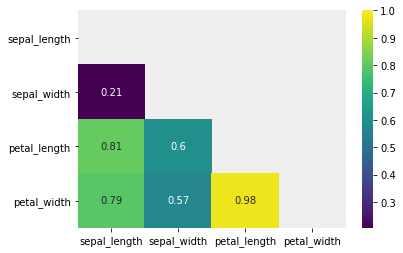

In [19]:
corr = iris[iris['species'] != 'virginica'].corr() 
mask = np.tri(*corr.shape).T   #只保留下三角部分
sns.heatmap(corr.abs(), mask=mask, annot=True, cmap='viridis')  #cmap：matplotlib 颜色条名称或者对象，或者是颜色列表，可选参数。
#annot:布尔值或者矩形数据，可选参数。如果为True，则在每个热力图单元格中写入数据值。 如果数组的形状与data相同，则使用它来代替原始数据注释热力图。
plt.savefig('B11197_04_07.png', dpi=300, bbox_inches='tight');

## Dealing with unbalanced classes

在每个类别具有完全相同数量的观测值的意义上，iris数据集是完全平衡的。 我们有50个setosas，50个versicolors和50个virgininas。 这是罗纳德·费舍尔（Ronald Fisher）所致，与他致力于普及使用p值不同。

相反，许多数据集由不平衡数据组成，也就是说，来自一个类别的数据点比来自另一个类别的数据点多。 发生这种情况时，逻辑回归可能会遇到麻烦，即无法像确定数据集更加平衡时那样准确地确定边界。

要查看此行为的示例，我们将使用iris数据集，并将从setosa类中任意删除一些数据点：

In [22]:
df = iris.query("species == ('setosa', 'versicolor')") 
df = df[45:]  
y_3 = pd.Categorical(df['species']).codes 
x_n = ['sepal_length', 'sepal_width'] 
x_3 = df[x_n].values

In [11]:
with pm.Model() as model_3: 
    α = pm.Normal('α', mu=0, sd=10) 
    β = pm.Normal('β', mu=0, sd=2, shape=len(x_n)) 
     
    μ = α + pm.math.dot(x_3, β) 
    θ = 1 / (1 + pm.math.exp(-μ)) 
    bd = pm.Deterministic('bd', -α/β[1] - β[0]/β[1] * x_3[:,0]) 
     
    yl = pm.Bernoulli('yl', p=θ, observed=y_3) 
 
    trace_3 = pm.sample(2000,cores=1,tune=1000,target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [β, α]
Sampling chain 1, 1 divergences: 100%|█████████████████████████████████████████████| 3000/3000 [00:31<00:00, 96.33it/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


C:\Users\zhaolei\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


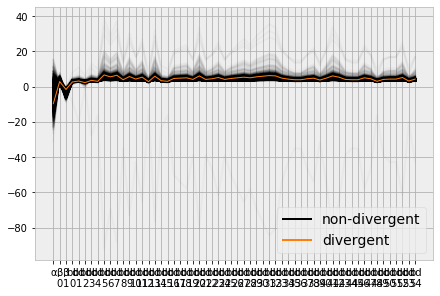

In [12]:
az.plot_parallel(trace_3)

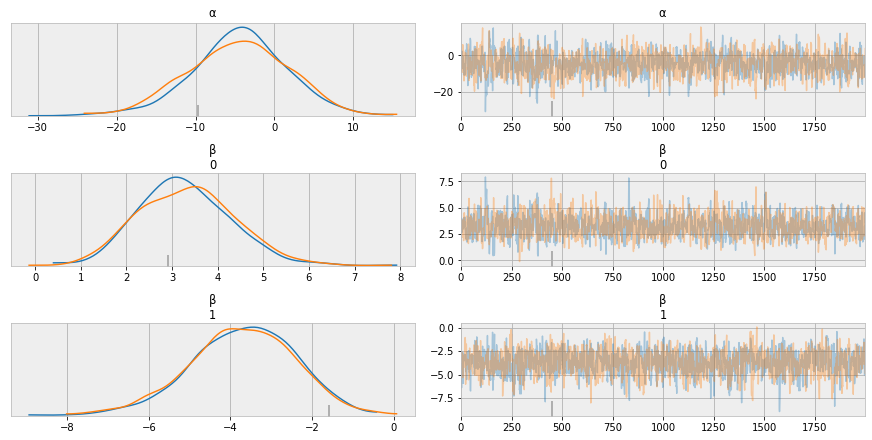

In [13]:
az.plot_trace(trace_3, varnames);

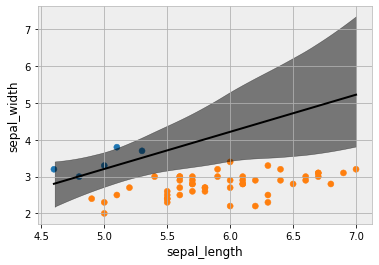

In [14]:
idx = np.argsort(x_3[:,0]) 
bd = trace_3['bd'].mean(0)[idx] 
plt.scatter(x_3[:,0], x_3[:,1], c= [f'C{x}' for x in y_3]) 
plt.plot(x_3[:,0][idx], bd, color='k')

az.plot_hpd(x_3[:,0], trace_3['bd'], color='k')

plt.xlabel(x_n[0]) 
plt.ylabel(x_n[1])

plt.savefig('B11197_04_08.png', dpi=300);

从图4.8中可以看出，边界决策现在已转向不那么丰富的类别，不确定性比以前更大。 这是不平衡数据的逻辑模型的典型行为。 但是请稍等！ 您可能会争辩说我在作弊，因为更大的不确定性可能是总数据更少而不是比杂色少的setosa的产物！ 那可能是一个正确的观点； 尝试练习6，以验证导致此图的是不平衡数据：

如果发现不平衡的数据该怎么办？ 好吧，显而易见的解决方案是获得每个类的数据点大致相同的数据集。 如果要收集或生成数据，请记住这一点很重要。 如果您无法控制数据集，则在解释不平衡数据的结果时应格外小心。 检查模型的不确定性，然后进行一些后验预测检查，以查看结果是否对您有用。 另一个选择是输入更多的先验信息（如果有），和/或运行其他模型，如本章稍后所述。

## Softmax regression

将logistic回归概括为两类以上的一种方法是使用softmax回归。 关于逻辑回归，我们需要引入两个变化； 首先，我们将logistic函数替换为softmax函数：

![title](4_9.png)

换句话说，要获得向量i-esim元素$\mu$的softmax函数的输出，我们将i-esim值的指数除以$ \mu $向量中所有指数值的总和 。

Softmax保证我们将得到总计为1的正值。当k = 2时，softmax函数将简化为对数函数。 附带说明一下，softmax函数的形式与统计力学中使用的玻耳兹曼分布相同，这是物理学中处理原子和分子系统的概率描述的一个非常强大的分支。 Boltzmann分布（在某些字段中为softmax）具有一个称为温度T的参数，该参数除以$ \mu $； 当T->无穷时，概率分布趋于平坦，并且所有状态的可能性均等；当T-> 0时，仅填充最可能的状态，因此softmax的行为类似于max函数。

第二个修改是我们用分类分布替换了伯努利分布。 类别分布是伯努利泛化为两个以上的结果。 同样，由于伯努利分布（单硬币翻转）是二项式（硬币翻转）的特殊情况，分类（丢一次骰子）是多项分布（丢n次骰子）的特殊情况。 您可以和您的侄女和侄子一起尝试这款益智游戏！

为了举例说明softmax回归，我们将继续使用iris数据集，仅这次我们将使用其三个类别（setosa，versicolor和virginica）及其四个特征（峰长，萼片宽度，花瓣长度， 和花瓣宽度）。 我们还将标准化数据，因为这将帮助采样器更有效地运行（我们也可以将数据居中）：

In [28]:
#iris = sns.load_dataset('iris')
iris = pd.read_csv('../data/iris.csv')
y_s = pd.Categorical(iris['species']).codes
x_n = iris.columns[:-1]
x_s = iris[x_n].values
x_s = (x_s - x_s.mean(axis=0)) / x_s.std(axis=0)
x_s.shape

(150, 4)

最早跑这个模型是崩溃的，改为Metropolis问题解决，然后解决gpu问题后，这个也能跑了，但速度非常慢，可见gpu并不适合并行任务。
https://www.cnblogs.com/citycomputing/p/11615104.html
    https://discourse.pymc.io/t/multiprocessing-windows-10-brokenpipeerror-errno-32-broken-pipe/2259/5

In [3]:
with pm.Model() as model_s:
    α = pm.Normal('α', mu=0, sd=5, shape=3)
    β = pm.Normal('β', mu=0, sd=5, shape=(4,3))
    μ = pm.Deterministic('μ', α + pm.math.dot(x_s, β))
    θ = tt.nnet.softmax(μ)
    yl = pm.Categorical('yl', p=θ, observed=y_s)
    #trace_s = pm.sample(2000)
    step = pm.Metropolis()
    trace_s = pm.sample(draws=2000, step=step)

C:\Users\zhaolei\Anaconda3\lib\site-packages\theano\tensor\subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
C:\Users\zhaolei\Anaconda3\lib\site-packages\theano\tensor\subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [β]
>Metropolis: [α]
Sampling 2 chains, 0 divergences: 100%|████████████████████████████████████████| 5000/5000 [00:12<00:00, 397.98draws/s]
C:\U

In [29]:
with pm.Model() as model_cpu_s:
    α = pm.Normal('α', mu=0, sd=5, shape=3)
    β = pm.Normal('β', mu=0, sd=5, shape=(4,3))
    μ = pm.Deterministic('μ', α + pm.math.dot(x_s, β))
    θ = tt.nnet.softmax(μ)
    yl = pm.Categorical('yl', p=θ, observed=y_s)
    trace_cpu_s = pm.sample(2000, cores=1)

C:\Users\zhaolei\Anaconda3\lib\site-packages\theano\tensor\subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
C:\Users\zhaolei\Anaconda3\lib\site-packages\theano\tensor\subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\zhaolei\Anaconda3\lib\site-packages\theano\tensor\subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimension

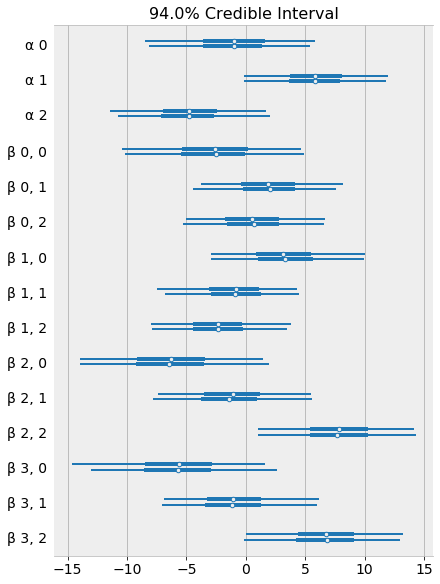

In [14]:
az.plot_forest(trace_s, var_names=['α', 'β']);

In [16]:
az.summary(trace_s ,var_names=['α', 'β'])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α[0],-1.101,3.751,-8.366,5.626,0.079,0.064,2237.0,1742.0,2281.0,1849.0,1.0
α[1],5.858,3.223,-0.145,11.885,0.062,0.046,2724.0,2487.0,2723.0,2721.0,1.0
α[2],-4.780,3.435,-10.889,2.088,0.065,0.048,2776.0,2541.0,2786.0,2831.0,1.0
"β[0,0]",-2.677,4.092,-10.183,4.889,0.068,0.063,3578.0,2120.0,3606.0,2368.0,1.0
"β[0,1]",1.922,3.253,-4.135,7.879,0.066,0.057,2428.0,1617.0,2438.0,2285.0,1.0
"β[0,2]",0.591,3.234,-5.314,6.546,0.065,0.061,2495.0,1407.0,2496.0,1949.0,1.0
"β[1,0]",3.265,3.445,-2.932,9.983,0.070,0.053,2414.0,2121.0,2416.0,2034.0,1.0
"β[1,1]",-0.930,3.085,-7.081,4.482,0.064,0.053,2314.0,1690.0,2308.0,2328.0,1.0
"β[1,2]",-2.355,3.115,-7.983,3.631,0.064,0.049,2350.0,2012.0,2346.0,2316.0,1.0
"β[2,0]",-6.342,4.285,-13.984,1.740,0.072,0.054,3509.0,3132.0,3512.0,2269.0,1.0


我们的模型表现如何？ 让我们通过检查可以正确预测多少个案例来找出答案。 在下面的代码中，我们仅使用参数的平均值来计算属于三个类中的每个类的每个数据点的概率，然后使用argmax函数分配该类。 然后将结果与观察值进行比较：

结果是我们对数据点进行了正确的分类，也就是说，我们仅遗漏了三种情况。 这是非常好的。 尽管如此，评估我们模型性能的真正测试是检查未用于拟合模型的数据。 否则，我们可能会高估模型对其他数据进行泛化的能力。 我们将在第5章“使用线性回归建模”中详细讨论该主题。 现在，我们将其保留为自动一致性测试，以指示模型运行正常。

In [50]:
data_pred = trace_cpu_s['μ'].mean(0)

y_pred = [np.exp(point)/np.sum(np.exp(point), axis=0)  #只是一维，所以axis=0  这个是还原softmax
          for point in data_pred]

f'{np.sum(y_s == np.argmax(y_pred, axis=1)) / len(y_s):.2f}'         #返回坐标，即【0.99,0.11,0.23】返回0
#二维数组，axis=1，是里面的一层

'0.98'

In [3]:
import numpy as np
a=np.array([[[4,2],[1,3]],[[12,14],[13,11]]])
print (a.sum(axis = 2),np.argmax(a,axis = 2))
print (a.sum(axis = 1),np.argmax(a,axis = 1))
print (a.sum(axis = 0),np.argmax(a,axis = 0))

[[ 6  4]
 [26 24]] [[0 1]
 [1 0]]
[[ 5  5]
 [25 25]] [[0 1]
 [1 0]]
[[16 16]
 [14 14]] [[1 1]
 [1 1]]


In [48]:
np.argmax(y_pred, axis=1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int64)

您可能已经注意到，每个参数的后验分布（或更恰当地说是边际分布）非常宽； 实际上，它们的宽度如先验所示。 即使我们能够做出正确的预测，这看起来也不行。 这与我们在其他回归模型或具有完全可分离类的关联数据中遇到的不可识别性问题相同。 在这种情况下，后验之所以宽泛是由于所有概率必须加起来得1的条件。 在这种情况下，我们使用的参数比完全指定模型所需的参数更多。 简单来说，如果您有十个数字加起来等于一，那么您只需要给我九个即可； 我可以计算的另一个。 一种解决方案是将额外参数固定为某个值，例如零。 以下代码显示了如何使用PyMC3实现此目的：

In [16]:
with pm.Model() as model_sf:
    α = pm.Normal('α', mu=0, sd=2, shape=2)
    β = pm.Normal('β', mu=0, sd=2, shape=(4,2))
    α_f = tt.concatenate([[0] ,α])  #α[2]=0
    β_f = tt.concatenate([np.zeros((4,1)) , β], axis=1)
    μ = α_f + pm.math.dot(x_s, β_f)
    θ = tt.nnet.softmax(μ)
    yl = pm.Categorical('yl', p=θ, observed=y_s)
    trace_sf = pm.sample(1000,cores=1)

C:\Users\zhaolei\Anaconda3\lib\site-packages\theano\tensor\subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\zhaolei\Anaconda3\lib\site-packages\theano\tensor\subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Sequential sampling (2 chains in 1 job)
NUTS: [β, α]
Sampling chain 1, 0 divergences: 100%|████████████████████████████████████████████| 1

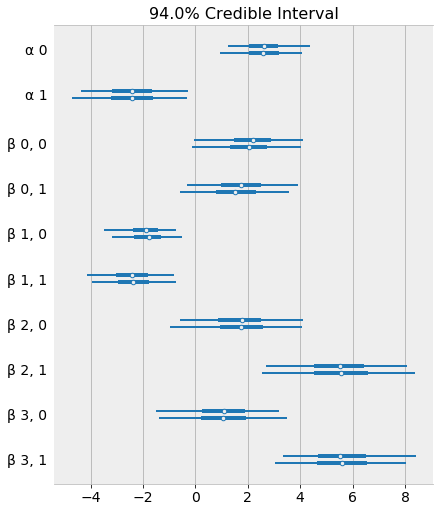

In [17]:
az.plot_forest(trace_sf, var_names=['α', 'β']);   #边际分布要窄了一些

## Discriminative and generative models 判别模型和生成模型

到目前为止，我们已经讨论了逻辑回归及其一些扩展。 在所有情况下，我们都尝试直接计算p（y | x），即给定类知道x的概率，其中x是我们对类成员测量的特征。 换句话说，我们尝试直接建模从独立变量到因变量的映射，然后使用阈值将连续计算的概率转换为允许我们分配类别的离散边界。

这种方法不是唯一的。 一个替代方案是首先对p（x | y）建模，即为每个类分配x的分布，然后分配这些类。 这种模型称为生成分类器，因为我们正在创建一个模型，可以从该模型中生成每个类的样本。 另一方面，逻辑回归是一种判别式分类器，因为它试图通过区分类来进行分类，但是我们无法从模型的每个类中生成示例。 在这里，我们将不涉及生成模型的更多详细信息，但是，我们将看到一个示例，它说明了这种类型的分类模型的核心。 我们将为两个类和仅一个功能执行此操作，与本章中建立的第一个模型（model_0）完全相同，并且我们将使用相同的数据。

以下是生成分类器的PyMC3实现。 从代码中，您可以看到现在将边界决策定义为估计的高斯均值之间的平均值。 当分布为正态且其标准偏差相等时，这是正确的边界决策。 这些是由称为线性判别分析（LDA）的模型做出的假设。 尽管它的名字，LDA模型是生成模型：

In [21]:
if __name__ == "__main__":
    with pm.Model() as lda:
        μ = pm.Normal('μ', mu=0, sd=10, shape=2)
        σ = pm.HalfNormal('σ', 10)
        setosa = pm.Normal('setosa', mu=μ[0], sd=σ, observed=x_0[:50])
        versicolor = pm.Normal('versicolor', mu=μ[1], sd=σ,
                           observed=x_0[50:])
        bd = pm.Deterministic('bd', (μ[0] + μ[1]) / 2)
        trace_lda = pm.sample(1000,cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [σ, μ]
Sampling chain 1, 0 divergences: 100%|████████████████████████████████████████████| 1500/1500 [00:01<00:00, 871.39it/s]
The acceptance probability does not match the target. It is 0.8834681240640975, but should be close to 0.8. Try to increase the number of tuning steps.


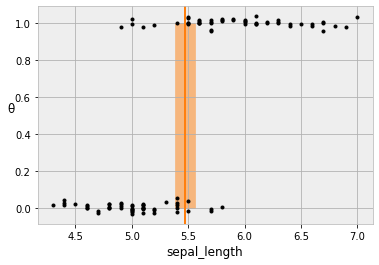

In [22]:
plt.axvline(trace_lda['bd'].mean(), ymax=1, color='C1')
bd_hpd = az.hpd(trace_lda['bd'])
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='C1', alpha=0.5)

plt.plot(x_0, np.random.normal(y_0, 0.02), '.', color='k')
plt.ylabel('θ', rotation=0)
plt.xlabel('sepal_length')
plt.savefig('B11197_04_09.png', dpi=300)

现在，我们将绘制一张图，显示这两个类别（setosa = 0和versicolor = 1）相对于萼片长度的值，以及作为红线和94％的最高后密度（HPD）区间的边界决策 因为它是半透明的红色带：

In [23]:
az.summary(trace_lda)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
μ[0],5.005,0.065,4.892,5.129,0.001,0.001,2087.0,2085.0,2085.0,1547.0,1.0
μ[1],5.937,0.064,5.826,6.066,0.001,0.001,2072.0,2071.0,2082.0,1631.0,1.0
σ,0.448,0.033,0.391,0.514,0.001,0.001,2033.0,2008.0,2067.0,1440.0,1.0
bd,5.471,0.046,5.387,5.561,0.001,0.001,2092.0,2089.0,2113.0,1508.0,1.0


LDA模型和逻辑回归均提供相似的结果。 通过将类别建模为多元高斯模型，可以将线性判别模型扩展到多个功能。 同样，可以放宽类具有共同方差（或协方差）的假设。 这导致了一个称为二次线性判别式（QDA）的模型，因为现在决策边界不是线性的而是二次的。

通常，当我们使用的功能或多或少是高斯分布时，LDA或QDA模型将比逻辑回归更好，而在相反情况下，逻辑回归将更好。 生成模型用于分类的优点之一是合并先验信息可能更容易或更自然。 例如，我们可能具有有关要纳入模型的数据均值和方差的信息。

重要的是要注意，LDA和QDA的边界决策是封闭形式的，因此通常以这种方式计算。要将LDA用于两个类别和一个特征，我们只需要计算每个分布的平均值并将这两个值取平均值，就可以得出边界决策。在前面的模型中，我们只是这样做了，但是有一个贝叶斯扭曲。我们估算了两个高斯的参数，然后将这些估算值插入到预定义的公式中。这些公式从何而来？好吧，无需太多细节，就可以得出该公式，我们必须假设数据是高斯分布的，因此，只有当数据没有偏离正态分布时，这种公式才有效。当然，如果我们想放宽正态性假设，例如使用学生的t分布（或多元学生的t分布，等等），可能会遇到问题。在这种情况下，我们不能再对LDA（或QDA）使用封闭格式；尽管如此，我们仍然可以使用PyMC3在数值上计算决策边界。

### The Poisson distribution

另一个非常流行的广义线性模型是泊松回归。 该模型假设数据是根据分布的，等待它...泊松分布。

泊松分布很有用的一种情况是在对事物进行计数时，例如放射性核的衰变，每对夫妇的孩子数或Twitter追随者的数量。 所有这些示例的共同之处在于，我们通常使用离散的非负数{0，1，2，3，....}对它们进行建模。 这种类型的变量接收计数数据的名称。

想象一下，我们正在计算每小时通过一条大道的红色汽车的数量。 我们可以使用泊松分布来描述此数据。 泊松分布通常用于描述在固定的时间/空间间隔内发生给定数量的事件的概率。 因此，泊松分布假设事件彼此独立发生并且以固定的时间间隔和/或空间发生。 仅使用一个值（比率，也通常用希腊字母表示）对这种离散分布进行参数化。 对应于均值，也对应于分布的方差。 泊松分布的概率质量函数如下：

![title](4_10.png)

注意$ \mu $可以是浮点数，但是分布的输出始终是整数。 在图4.10中，点代表分布的值，而实线是帮助我们轻松掌握分布形状的视觉辅助。 请记住，泊松分布是离散分布。

当试验次数很大但成功的可能性很低时，泊松分布可以看作是二项式分布的特例。 在不赘述过多数学细节的情况下，让我们尝试澄清一下这一说法。 在汽车示例之后，我们可以确定我们看到的是红色汽车还是看不到红色汽车，因此可以使用二项分布。 在这种情况下，我们有：

![title](4_11.png)

但是请注意，即使您在繁忙的大街上，与城市的汽车总数相比，看到红色汽车的机会也很小，因此，我们有：

![title](4_12.png)

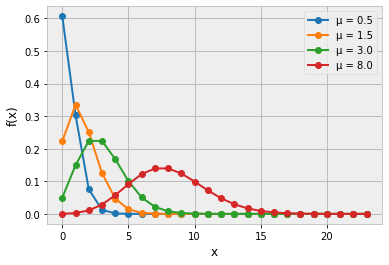

In [24]:
mu_params = [0.5, 1.5, 3, 8]
x = np.arange(0, max(mu_params) * 3)
for mu in mu_params:
    y = stats.poisson(mu).pmf(x)
    plt.plot(x, y, 'o-', label=f'μ = {mu:3.1f}')
plt.legend()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.savefig('B11197_04_10.png', dpi=300);

## The Zero-Inflated Poisson model 零膨胀泊松模型

在计算事物时，一种选择是不对事物进行计数，即得到零。 数字零通常可能由于多种原因而出现。 我们之所以归零，是因为我们当时在计算红色轿车的数量，而红色轿车没有通过大道，或者因为我们错过了它（也许我们没有看到那辆大卡车后面的那个红色小轿车）。 因此，如果我们使用泊松分布，例如，当执行后验预测检查时，与数据相比，该模型生成的零更少。 我们该如何解决？ 我们可能会尝试解决模型的确切原因，即预测比观察到的零更少，并将该因素包括在模型中。 但是，通常情况下，假设我们混合了两个过程，就足以满足我们的目的：

一个用泊松分布建模的概率ψ

一个以概率给出额外的零 1-ψ

这就是所谓的零膨胀泊松（ZIP）模型。 在某些文本中，您会发现它表示额外的零和泊松概率。 这没什么大不了的。 请注意哪个是哪个具体示例。

![title](4_13.png)

ψ泊松变量的预期比例（0 <ψ <1）

θ在给定间隔（θ> = 0）内的预期出现次数。

In [67]:
counts 

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 4, 0, 1, 0, 0, 0, 0, 0, 4, 3, 0, 6,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [66]:
n = 100
θ_real = 2.5
ψ = 0.1

# Simulate some data
counts = np.array([(np.random.random() > (1-ψ)) *    #从0-1中随机
                   np.random.poisson(θ_real) for i in range(n)])

In [3]:
with pm.Model() as ZIP:
    ψ = pm.Beta('ψ', 1, 1)  #[0-1]
    θ = pm.Gamma('θ', 2, 0.1)  #泊松的先验
    y = pm.ZeroInflatedPoisson('y', ψ, θ,
                               observed=counts)
    trace = pm.sample(1000,cores=1)

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '19356' (I am process '19764')
C:\Users\zhaolei\Anaconda3\lib\site-packages\theano\gpuarray\dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [θ, ψ]
Sampling chain 1, 0 divergences: 100%|███████████████████████████████████████████| 1500/1500 [00:01<00:00, 1079.69it/s]


C:\Users\zhaolei\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\zhaolei\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\zhaolei\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\zhaolei\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument

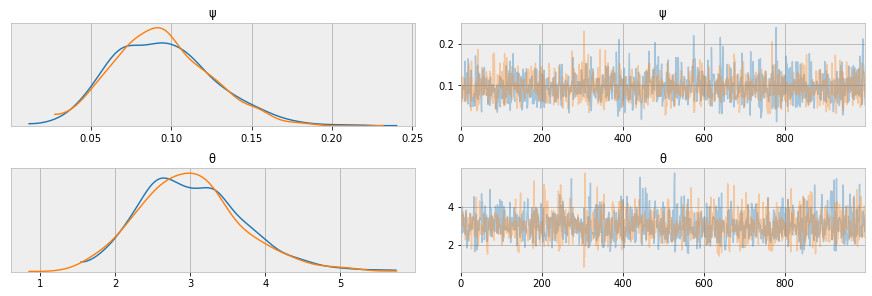

In [4]:
az.plot_trace(trace)
plt.savefig('B11197_04_11.png', dpi=300);

In [5]:
az.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
ψ,0.095,0.031,0.042,0.155,0.001,0.001,1817.0,1783.0,1783.0,1167.0,1.0
θ,3.022,0.688,1.740,4.290,0.016,0.012,1775.0,1750.0,1750.0,1096.0,1.0


## Poisson regression and ZIP regression

ZIP模型可能看起来有些沉闷，但有时我们需要估算简单的分布（例如此分布）或其他分布（例如泊松或高斯分布）。 无论如何，我们也可以使用泊松或ZIP分布作为线性模型的一部分。 正如我们在logistic和softmax回归中所看到的，我们可以使用逆链接函数将线性模型的结果转换为适合与除正态分布外的其他分布一起使用的范围内的变量。 按照相同的想法，我们现在可以执行回归分析，其中输出变量是使用泊松或ZIP分布的计数变量。 这次，我们可以将指数函数e用作反向链接函数。 此选择确保线性模型返回的值始终为正：

![title](4_14.png)

为了举例说明ZIP回归模型的实现，我们将使用从数字研究与教育学院获取的数据集。 我们有250名游客到公园。 以下是每组数据的某些部分

The number of fish they caught ( count )

How many children were in the group ( child )

Whether they brought a camper to the park ( camper )

In [69]:
fish_data = pd.read_csv('../data/fish.csv')

In [70]:
fish_data

,nofish,livebait,camper,persons,child,xb,zg,count
0,1,0,0,1,0,-0.896315,3.050405,0
1,0,1,1,1,0,-0.558345,1.746149,0
2,0,1,0,1,0,-0.401731,0.279939,0
3,0,1,1,2,1,-0.956298,-0.601526,0
4,0,1,0,1,0,0.436891,0.527709,1
...,...,...,...,...,...,...,...,...
245,1,1,1,2,0,-0.755236,2.324209,0
246,0,1,1,4,3,1.794859,-5.625944,0
247,0,1,1,2,1,-0.392649,0.677275,0
248,1,1,1,3,2,1.374641,-2.595630,0


In [71]:
fish_data.describe()

,nofish,livebait,camper,persons,child,xb,zg,count
count,250.000000,250.000000,250.000000,250.00000,250.000000,250.000000,250.000000,250.000000
mean,0.296000,0.864000,0.588000,2.52800,0.684000,0.973796,0.252323,3.296000
std,0.457407,0.343476,0.493182,1.11273,0.850315,1.440277,2.102391,11.635028
min,0.000000,0.000000,0.000000,1.00000,0.000000,-3.275050,-5.625944,0.000000
25%,0.000000,1.000000,0.000000,2.00000,0.000000,0.008267,-1.252724,0.000000
50%,0.000000,1.000000,1.000000,2.00000,0.000000,0.954550,0.605079,0.000000
75%,1.000000,1.000000,1.000000,4.00000,1.000000,1.963855,1.993237,2.000000
max,1.000000,1.000000,1.000000,4.00000,3.000000,5.352674,4.263185,149.000000


Camper是一个二进制变量，其值为0f表示非camper，值为1，表示camper。 指示属性不存在/存在的变量通常表示为虚拟变量或指示符变量。 请注意，当camper的值为0时，所涉及的项也将为0，并且该模型将减少为具有单个自变量的回归。

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [β, α, ψ]
Sampling chain 1, 0 divergences: 100%|████████████████████████████████████████████| 1500/1500 [00:08<00:00, 178.86it/s]


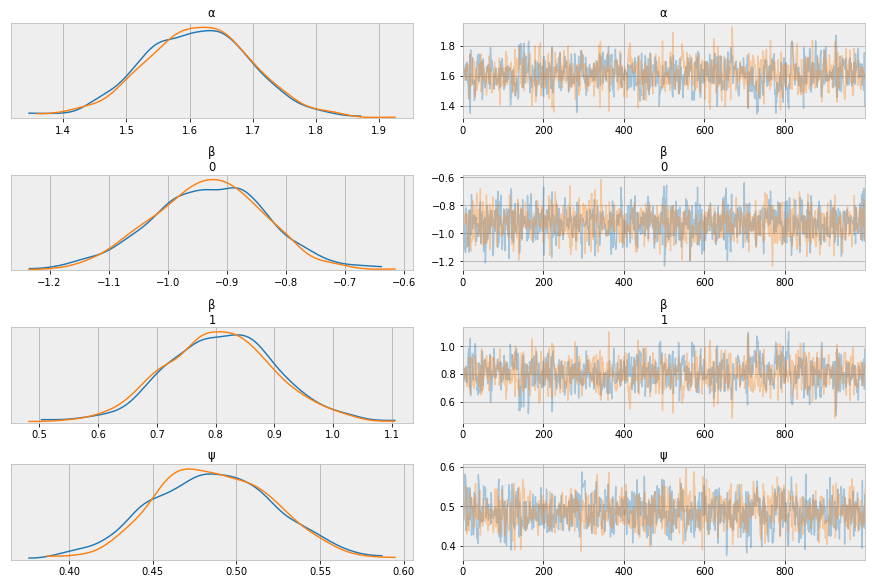

In [72]:
with pm.Model() as ZIP_reg:
    ψ = pm.Beta('ψ', 1, 1)
    α = pm.Normal('α', 0, 10)
    β = pm.Normal('β', 0, 10, shape=2)
    θ = pm.math.exp(α + β[0] * fish_data['child'] + β[1] * fish_data['camper'])   #在rethink书上，还有一个偏移曝光量的问题，大家在公园时间
    #的不同会导致钓鱼的不同
    yl = pm.ZeroInflatedPoisson('yl', ψ, θ, observed=fish_data['count'])
    trace_ZIP_reg = pm.sample(1000,cores=1)
az.plot_trace(trace_ZIP_reg);

In [11]:
az.summary(trace_ZIP_reg)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α,1.611,0.092,1.447,1.791,0.003,0.002,858.0,858.0,855.0,999.0,1.0
β[0],-0.927,0.096,-1.104,-0.744,0.003,0.002,1248.0,1248.0,1249.0,1130.0,1.0
β[1],0.808,0.099,0.623,0.993,0.003,0.002,858.0,853.0,858.0,976.0,1.0
ψ,0.486,0.035,0.423,0.553,0.001,0.001,1282.0,1263.0,1283.0,1059.0,1.0


In [29]:
np.exp(1.611-0.927*2)

0.7842715137715564

In [24]:
fish_count_pred_1[2].mean()

1.7902758

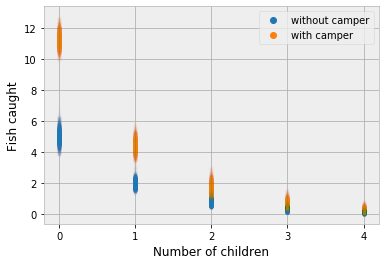

In [74]:
children = [0, 1, 2, 3, 4]
fish_count_pred_0 = []
fish_count_pred_1 = []
for n in children:
    without_camper = trace_ZIP_reg['α'] + trace_ZIP_reg['β'][:,0] * n
    with_camper = without_camper + trace_ZIP_reg['β'][:,1]
    fish_count_pred_0.append(np.exp(without_camper))
    fish_count_pred_1.append(np.exp(with_camper))
    
    
plt.plot(children, fish_count_pred_0, 'C0.', alpha=0.01)
plt.plot(children, fish_count_pred_1, 'C1.', alpha=0.01)

plt.xticks(children);
plt.xlabel('Number of children')
plt.ylabel('Fish caught')
plt.plot([], 'C0o', label='without camper')
plt.plot([], 'C1o', label='with camper')
plt.legend()
plt.savefig('B11197_04_12.png', dpi=300);

从图4.12中可以看出，孩子的数量越高，捕获的鱼的数量就越少。 同样，与露营者一起旅行的人通常会钓到更多的鱼。 如果检查儿童和露营者的$ \beta $系数，您会看到我们可以说以下内容：
每增加一个孩子，预期捕捞的鱼数量减少0.4
在露营者中增加了被捕到的鱼的预期数量2
我们通过分别取$ \beta1 $和$ \beta2 $的指数得出这些值。

## Robust logistic regression
我们只是看到了如何在不直接建模生成零的因子的情况下修复过多的零。 Kruschke建议的类似方法可用于执行Logistic回归的更强大版本。 请记住，在逻辑回归中，我们将数据建模为二项式，即零和一。 因此，可能会发现我们发现一个具有异常零和/或一的数据集。 以我们已经看到的虹膜数据集为例，但其中添加了一些入侵者：

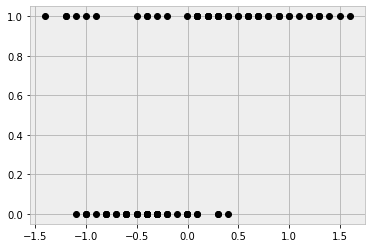

In [15]:
#iris = sns.load_dataset("iris") 
df = iris.query("species == ('setosa', 'versicolor')") 
y_0 = pd.Categorical(df['species']).codes 
x_n = 'sepal_length'  
x_0 = df[x_n].values 
y_0 = np.concatenate((y_0, np.ones(6, dtype=int))) 
x_0 = np.concatenate((x_0, [4.2, 4.5, 4.0, 4.3, 4.2, 4.4])) 
x_c = x_0 - x_0.mean() 
plt.plot(x_c, y_0, 'o', color='k');

In [16]:
x_0.mean() 

5.402830188679245

在这里，我们有些杂色（1s）的萼片长度异常短。 我们可以用混合模型来解决这个问题。 我们要说的是，输出变量通过随机猜测具有π概率，或者具有从逻辑回归模型获得的1-π概率。 从数学上讲，我们有：

![title](4_15.png)

对比之前的模型：
 θ = pm.Deterministic('θ', pm.math.sigmoid(μ))
 
 bd = pm.Deterministic('bd', -α/β)
 
 yl = pm.Bernoulli('yl', p=θ, observed=y_0)

In [17]:
with pm.Model() as model_rlg:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=10)
    
    μ = α + x_c *  β  
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ))
    bd = pm.Deterministic('bd', -α/β)
    
    π = pm.Beta('π', 1., 1.) 
    p = π * 0.5 + (1 - π) * θ 
    
    yl = pm.Bernoulli('yl', p=p, observed=y_0)

    trace_rlg = pm.sample(1000,cores=1,tune=1000,target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [π, β, α]
Sampling chain 1, 0 divergences: 100%|████████████████████████████████████████████| 2000/2000 [00:05<00:00, 387.25it/s]


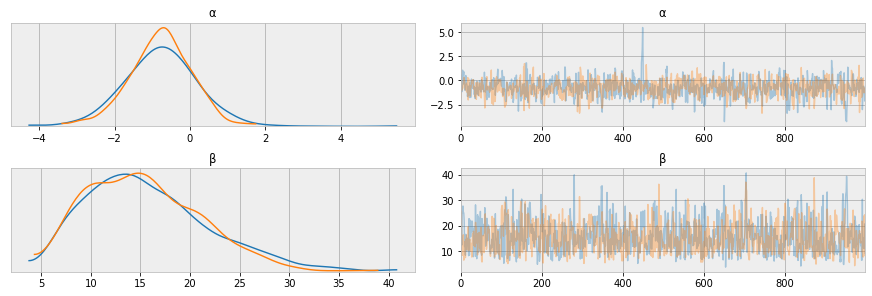

In [18]:
az.plot_trace(trace_rlg, varnames);

In [19]:
varnames = ['α', 'β', 'bd']
az.summary(trace_rlg, varnames)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α,-0.770,0.890,-2.402,0.897,0.028,0.023,1031.0,764.0,1024.0,995.0,1.0
β,15.646,5.998,6.129,26.878,0.195,0.141,946.0,908.0,1000.0,952.0,1.0
bd,0.048,0.057,-0.072,0.150,0.002,0.001,1370.0,1370.0,1322.0,1197.0,1.0


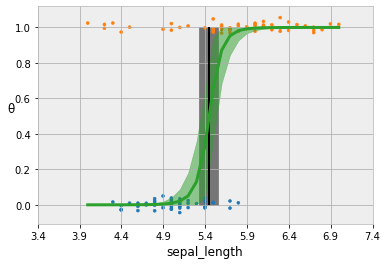

In [20]:
theta = trace_rlg['θ'].mean(axis=0)
idx = np.argsort(x_c)
plt.plot(x_c[idx], theta[idx], color='C2', lw=3);
plt.vlines(trace_rlg['bd'].mean(), 0, 1, color='k')
bd_hpd = az.hpd(trace_rlg['bd'])

plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='k', alpha=0.5)

plt.scatter(x_c, np.random.normal(y_0, 0.02), marker='.', color=[f'C{x}' for x in y_0])
theta_hpd = az.hpd(trace_rlg['θ'])[idx]
plt.fill_between(x_c[idx], theta_hpd[:,0], theta_hpd[:,1], color='C2', alpha=0.5)

plt.xlabel(x_n)
plt.ylabel('θ', rotation=0)
# use original scale for xticks
locs, _ = plt.xticks() 
plt.xticks(locs, np.round(locs + x_0.mean(), 1))
plt.savefig('B11197_04_13.png', dpi=300);

### 广义线性模型
正如我们在本章开头所讨论的那样，线性模型是非常有用的统计工具。 像我们在本章中看到的那样的扩展使它们成为更通用的工具。 因此，PyMC3包含一个用于简化线性模型创建的模块：广义线性模型（GLM）模块。 例如，简单的线性回归将如下所示：

with pm. Model() as model:

glm. glm(' y ~ x' , data)

trace = sample(2000)

前面代码的第二行负责为截距和斜率添加先验。 默认情况下，截距被指定为平坦先验，斜率被指定为先验。 请注意，默认模型的最大后验（MAP）将基本上等于使用普通最小二乘法获得的后验。 作为默认的线性回归，这些都很好。 您可以使用Priors参数更改它。 默认情况下，GLM模块还会添加高斯似然。 您可以使用family参数进行更改。 您可以从以下选项中选择：正态分布（默认），StudentT，Binomial，Poisson或NegativeBinomial（gamma-possion）。

为了描述统计模型，GLM模块使用了Patsy（https://patsy.readthedocs.io/en/latest/index.html ），这是一个Python库，它提供了一种受公式启发的公式迷你语言语法。 R和S。在上一个代码块中，y〜x指定我们有一个输出变量y，我们希望将其估计为x的线性函数。

### 总结
本章讨论的主要思想很简单：为了预测输出变量的均值，我们可以将任意函数应用于输入变量的线性组合。 我知道我已经在本章开头说过了，但是重复很重要。 我们称该任意函数为反向链接函数。 我们选择这种函数的唯一限制是输出必须足够用作采样分布的参数（通常是平均值）。 我们希望使用逆链接函数的一种情况是使用分类变量，另一种情况是数据只能取正值，而另一种情况是我们需要[0，1]区间的变量。 所有这些不同的变体成为不同的模型。 这些模型中有许多通常用作统计工具，并且已经研究了它们的应用和统计特性。

逻辑回归模型是前一章中线性回归模型的概括，可用于分类或一般用于预测二项式数据。 Logistic回归的显着特征是使用logistic作为反向链接函数，并使用Bernoulli分布作为可能性。 反向链接函数的使用引入了非线性，在解释逻辑回归的系数时应将其考虑在内。 该系数通过x变量的单位增加来编码对数奇数单位的增加。

将logistic回归概括为两类以上的一种方法是使用softmax回归。 现在，反向链接函数是softmax函数，它是Logistic函数对两个以上值的推广，并且使用分类分布作为似然性。

logistic和softmax都是判别模型的示例； 我们尝试在没有显式建模的情况下进行建模。 用于分类的生成模型将首先对进行建模，即为每个类分配，然后分配类。 这种模型称为生成分类器，因为我们正在创建一个模型，可以从该模型中生成每个类的样本。 我们看到了一个使用高斯分布的生成分类器的例子。

我们使用虹膜数据集演示了所有这些模型，并简要讨论了相关变量，完全可分离的类和不平衡的类。

另一个流行的广义线性模型是泊松回归。 该模型假设数据是根据泊松分布进行分布的，并且反向链接函数是指数函数。 泊松分布和回归模型可用于对计数数据进行建模，也就是说，仅采用非负整数的数据是由计数而非排名产生的。 大多数分布之间相互关联； 一个例子是高斯和学生的t分布。 另一个例子是泊松分布，当试验次数很大但成功的可能性很低时，它可以看作是二项式分布的特例。

ZIP分布是扩展Poisson分布的一种有用方法。 我们可以将后者视为其他两个分布的混合：泊松分布和生成额外零的二进制分布。 可以解释为混合的另一个有用扩展是负二项式分布-在这种情况下是泊松分布的混合，其中比率（$ \ mu $）是作为伽马分布分布的随机变量。 当数据过于分散时，负二项式是泊松分布的有用替代方法，也就是说，数据的方差大于平均值。